# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

In [2]:
import pickle
#please use below code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [3]:
#As title feature is not present in preprocessing.csv so we are preprocessing our title from training set and getting value 
project_data = pd.read_csv('train_data.csv')


In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [5]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [6]:

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [7]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|████████████████████████████████| 109248/109248 [00:01<00:00, 57195.95it/s]


In [8]:
from sklearn.feature_extraction.text import HashingVectorizer 
import numpy as np 

In [9]:
#df = pd.read_csv("preprocessed_data.csv")
#df["project_title"] = preprocessed_titles
#df.to_csv("preprocessed_data.csv", index=False)

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [10]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

print(data.columns.values)

['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price' 'project_title']


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [11]:


from sklearn.model_selection import train_test_split
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)


X = X[0:35000]
y = y[0:35000]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)



(35000, 9)
(35000,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

<h3>1.3.1 Encoding essay and title using sentiment scores </h3>

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

X_train_essay_sentiment = pd.DataFrame(columns=['essay_neg', 'essay_neu', 'essay_pos','essay_compound'])

essays = X_train['essay']
for essay in essays:
    res = sid.polarity_scores(essay)
    X_train_essay_sentiment = X_train_essay_sentiment.append({'essay_neg': res["neg"], 'essay_neu':  res["neg"],'essay_pos':res["pos"], 'essay_compound':res["compound"]}, ignore_index=True)
    





In [13]:
X_train_essay_sentiment.head()
print(X_train_essay_sentiment.shape)

(23450, 4)


In [14]:
sid = SentimentIntensityAnalyzer()

X_test_essay_sentiment = pd.DataFrame(columns=['essay_neg', 'essay_neu', 'essay_pos','essay_compound'])

essays = X_test['essay']
for essay in essays:
    res = sid.polarity_scores(essay)
    X_test_essay_sentiment = X_test_essay_sentiment.append({'essay_neg': res["neg"], 'essay_neu':  res["neg"],'essay_pos':res["pos"], 'essay_compound':res["compound"]}, ignore_index=True)
    



In [15]:
X_test_essay_sentiment.head()
print(X_test_essay_sentiment.shape)

(11550, 4)


<h3>1.3.2 Encoding Essay and Tile Feature(Tfidf)</h3>

In [16]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
from sklearn.feature_extraction.text import TfidfVectorizer
print("Vectorization of Essay Feature in TFIDF")

vectorizer_tfidf = TfidfVectorizer(min_df=10,max_features=5000)
vectorizer_tfidf.fit(X_train["essay"].values)

#Converting text to vector TfIdf
X_train_essay_tfidf = vectorizer_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test['essay'].values)


print("After vectorizations of Essay Feature")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

print("Vectorization of Title Feature in TFIDF")
vectorizer_tfidf = TfidfVectorizer(min_df=10,max_features=5000)
vectorizer_tfidf.fit(X_train["project_title"].values.astype('U'))

#Converting text to vector TfIdf
X_train_title_tfidf = vectorizer_tfidf.transform(X_train['project_title'].values.astype('U'))
X_test_title_tfidf = vectorizer_tfidf.transform(X_test['project_title'].values.astype('U'))


print("After vectorizations of Title Feature")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

Vectorization of Essay Feature in TFIDF
After vectorizations of Essay Feature
(23450, 5000) (23450,)
(11550, 5000) (11550,)
Vectorization of Title Feature in TFIDF
After vectorizations of Title Feature
(23450, 1226) (23450,)
(11550, 1226) (11550,)


<h3>1.3.3 Encoding Essay and Title feature(TfidfW2V)</h3>

In [17]:
#tfidfwzv
from scipy import sparse
tfidf_model = TfidfVectorizer(min_df=10,max_features=5000)
tfidf_model.fit(X_train["essay"].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


def convertToTfIdfW2v(feature):
    tfidfw2v = []
    for sentence in feature.values:
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if((word in glove_words) and (word in tfidf_words)):
                vec = model[word]
                tfidf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector+=vec*tfidf
                tf_idf_weight+=tfidf
        if tf_idf_weight !=0:
            vector/=tf_idf_weight
        tfidfw2v.append(vector)
    return sparse.csr_matrix(tfidfw2v)

In [18]:
print("Vectorization of Essay Feature in TFIDF W2V")
X_train_essay_tfidfw2v = convertToTfIdfW2v(X_train["essay"])
X_test_essay_tfidfw2v = convertToTfIdfW2v(X_test["essay"])
 
print("After vectorizations of Essay Feature")
print(X_train_essay_tfidfw2v.shape, y_train.shape)
print(X_test_essay_tfidfw2v.shape, y_test.shape)
print("="*100)



Vectorization of Essay Feature in TFIDF W2V
After vectorizations of Essay Feature
(23450, 300) (23450,)
(11550, 300) (11550,)


In [19]:
tfidf_model = TfidfVectorizer(min_df=10,max_features=5000)
tfidf_model.fit(X_train["essay"].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

print("Vectorization of Title Feature in TFIDF W2V")
X_train_title_tfidfw2v = convertToTfIdfW2v(X_train["project_title"].fillna(""))
X_test_title_tfidfw2v = convertToTfIdfW2v(X_test["project_title"].fillna(""))
 
print("After vectorizations of Title Feature")
print(X_train_title_tfidfw2v.shape, y_train.shape)
print(X_test_title_tfidfw2v.shape, y_test.shape)
print("="*100)


Vectorization of Title Feature in TFIDF W2V
After vectorizations of Title Feature
(23450, 300) (23450,)
(11550, 300) (11550,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 Encoding numberical features </h3>

In [20]:
#Vectorizing price(numerical feature)
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["price"].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("After vectorizations")

print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100) 



After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


In [21]:
#Vectorizing teacher_number_of_previously_posted_projects(numerical feature)
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))

X_train_tnp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_tnp_norm.shape, y_train.shape)
print(X_test_tnp_norm.shape, y_test.shape)
print("="*100) 

After vectorizations
(23450, 1) (23450,)
(11550, 1) (11550,)


<h3>1.4.2 Encoding categorical features with response coding </h3>

In [22]:
#Reference : https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data


def get_fea_dict(alpha, feature, train_df, train_df_y):
    # value_count: it contains a dict like
    value_count = train_df[feature].value_counts()
    
    # feat_dict : Categorical feature Dict, which contains the probability array for each categorical variable
    feat_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of the particular 
        # categorical feature belongs to particular class
        # vec is 2 diamensional vector
        vec = []
        for k in range(0, 2):
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df_y==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 20*alpha))

        # we are adding the categorical feature to the dict as key and vec as value
        feat_dict[i]=vec
    return feat_dict

# Get Response coded feature
def get_response_feature(alpha, feature, train_df, train_df_y):

    feat_dict = get_fea_dict(alpha, feature, train_df, train_df_y)
    # value_count is similar in get_fea_dict
    value_count = train_df[feature].value_counts()
    
    # res_fea: response coded feature, it will contain the response coded feature for each feature value in the data
    res_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to res_fea
    # if not we will add [1/2, 1/2] to res_fea
    for index, row in train_df.iterrows():
        if row[feature] in dict(value_count).keys():
            res_fea.append(feat_dict[row[feature]])
        else:
            res_fea.append([1/2, 1/2])
    return res_fea

def ResponseEncoder(categorical_cols, x_df, y_df):
    for i in (categorical_cols):
        temp_response_coded_feature = np.array(get_response_feature(alpha=1, feature=i, train_df=x_df, train_df_y=y_df))
        df_response = pd.DataFrame(temp_response_coded_feature, columns=[i+"_0", i+"_1"])
        x_df = pd.concat([x_df, df_response], axis=1)

    # Remove the categorical features as the response coded features are added
    x_df = x_df.drop(categorical_cols, axis=1)
    return x_df

In [23]:
categorical_cols = ['clean_categories','clean_subcategories','school_state','teacher_prefix' ,'project_grade_category']

X_train_response_encoded_cat_features = X_train[categorical_cols]
X_test_response_encoded_cat_features = X_test[categorical_cols]



# Reset index so that pd.concat works properly in ResponseEncoder function
X_train_response = X_train_response_encoded_cat_features.reset_index().drop("index",axis=1)
X_test_response = X_test_response_encoded_cat_features .reset_index().drop("index",axis=1)


X_train_response_encoded_cat_features = ResponseEncoder(categorical_cols,X_train_response, y_train)
X_test_response_encoded_cat_features = ResponseEncoder(categorical_cols,X_test_response, y_test)



In [24]:
print(X_train_response_encoded_cat_features.shape)
print(X_test_response_encoded_cat_features.shape)

(23450, 10)
(11550, 10)


<h3>1.4.3 Making Data Model Ready </h3>

In [25]:
from scipy.sparse import hstack

X_tr1 = hstack((X_train_essay_sentiment,X_train_essay_tfidf,X_train_title_tfidf,X_train_response_encoded_cat_features,X_train_price_norm,X_train_tnp_norm)).tocsr()
X_te1 = hstack((X_test_essay_sentiment,X_test_essay_tfidf,X_test_title_tfidf,X_test_response_encoded_cat_features,X_test_price_norm,X_test_tnp_norm)).tocsr()

print("Final Data matrix 1")
print(X_tr1.shape, y_train.shape)
print(X_te1.shape, y_test.shape)
print("="*100)

X_tr2 = hstack((X_train_essay_sentiment,X_train_essay_tfidfw2v,X_train_title_tfidfw2v,X_train_response_encoded_cat_features,X_train_price_norm,X_train_tnp_norm)).tocsr()
X_te2 = hstack((X_test_essay_sentiment,X_test_essay_tfidfw2v,X_test_title_tfidfw2v,X_test_response_encoded_cat_features,X_test_price_norm,X_test_tnp_norm)).tocsr()

print("Final Data matrix 2")
print(X_tr2.shape, y_train.shape)
print(X_te2.shape, y_test.shape)
print("="*100)

Final Data matrix 1
(23450, 6242) (23450,)
(11550, 6242) (11550,)
Final Data matrix 2
(23450, 616) (23450,)
(11550, 616) (11550,)


<h2>1.5 Applying Best Model on Category 1 features</h2>

<h3>1.5.1 Hyperparameter Tuning </h3>

In [26]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators=[5,10,50, 75]
parameters = {  'learning_rate': learning_rate, 
                    'n_estimators': n_estimators }
model = lgb.LGBMClassifier(boosting_type='gbdt')
clf = GridSearchCV(model, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

In [27]:
clf.fit(X_tr1,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': [5, 10, 50, 75]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [28]:
#best average training scores for each split
train_auc1= clf.cv_results_['mean_train_score']
train_auc_std1= clf.cv_results_['std_train_score']

#best average test scores for each split
cv_auc1 = clf.cv_results_['mean_test_score']
cv_auc_std1= clf.cv_results_['std_test_score']

#best hyperparameters from all 16 values
bestLearningRate1=clf.best_params_['learning_rate']
bestNEstimators1=clf.best_params_['n_estimators']

#overall best AUC score 
bestScore1=clf.best_score_

print("Best learning_rate :",bestLearningRate1)
print("Best n_estimators :",bestNEstimators1)
print("Best AUC Score :",bestScore1)




Best learning_rate : 0.1
Best n_estimators : 75
Best AUC Score : 0.7026082977131534


<h3>1.5.2 Creating Heatmap </h3>

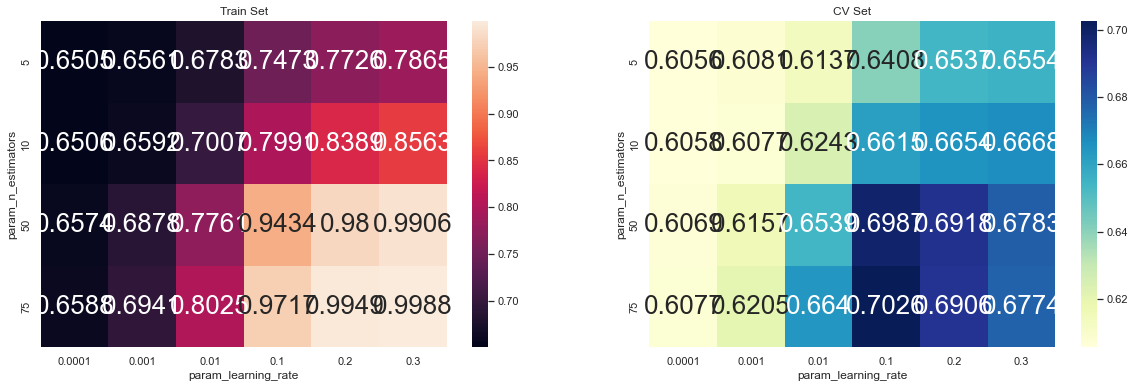

In [29]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_learning_rate']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

<h3>1.5.3 Best Model with Category 1 features <h3>

In [30]:
best_model_tfidf= lgb.LGBMClassifier(boosting_type='gbdt',learning_rate=bestLearningRate1,n_estimators=bestNEstimators1)
best_model_tfidf.fit(X_tr1,y_train)

LGBMClassifier(n_estimators=75)

In [31]:
y_train_pred=best_model_tfidf.predict_proba(X_tr1)[:,1]
predictions_train_set1=best_model_tfidf.predict(X_tr1)

y_test_pred=best_model_tfidf.predict_proba(X_te1)[:,1]
predictions_test_set1=best_model_tfidf.predict(X_te1)

<h3>1.5.4 Drawing AUC Curve </h3>

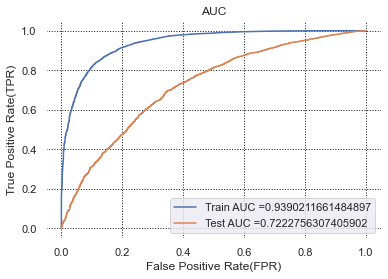

In [32]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)


ax = plt.subplot()

aucScoreTrainingData=auc(train_fpr, train_tpr)
aucScoreTestData=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<h3>1.5.5 Confusion Matrix </h3>

In [33]:
def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



the maximum value of tpr*(1-fpr) 0.7461081304677895 for threshold 0.814

Train confusion matrix


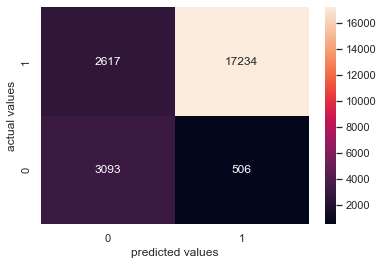

Test confusion matrix


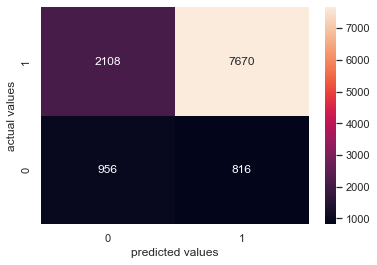

In [34]:
from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print()
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(y_train, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx = sns.heatmap(confusion_matrix(y_test, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

<h2>1.6 Applying Best Model To Category 2 features</h2>

<h3>1.6.1 Hyperparameter Tuning </h3>

In [35]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

learning_rate1 = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators1=[5,10,50,75]
parameters1 = {  'learning_rate':learning_rate1, 
                    'n_estimators': n_estimators1 }
model1 = lgb.LGBMClassifier(boosting_type='gbdt')
clf1 = GridSearchCV(model1, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

In [36]:
clf1.fit(X_tr2,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                         'n_estimators': [5, 10, 50, 75]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [37]:
#best average training scores for each split
train_auc2= clf1.cv_results_['mean_train_score']
train_auc_std2= clf1.cv_results_['std_train_score']

#best average test scores for each split
cv_auc2= clf1.cv_results_['mean_test_score']
cv_auc_std2= clf1.cv_results_['std_test_score']

#best hyperparameters from all 16 values
bestLearningRate2=clf1.best_params_['learning_rate']
bestNEstimators2=clf1.best_params_['n_estimators']

#overall best AUC score 
bestScore2=clf.best_score_

print("Best Learning Rate :",bestLearningRate2)
print("Best N Estimator Value :",bestNEstimators2)
print("Best AUC Score :",bestScore2)





Best Learning Rate : 0.1
Best N Estimator Value : 50
Best AUC Score : 0.7026082977131534


<h3>1.6.2 Creating Heatmap </h3>

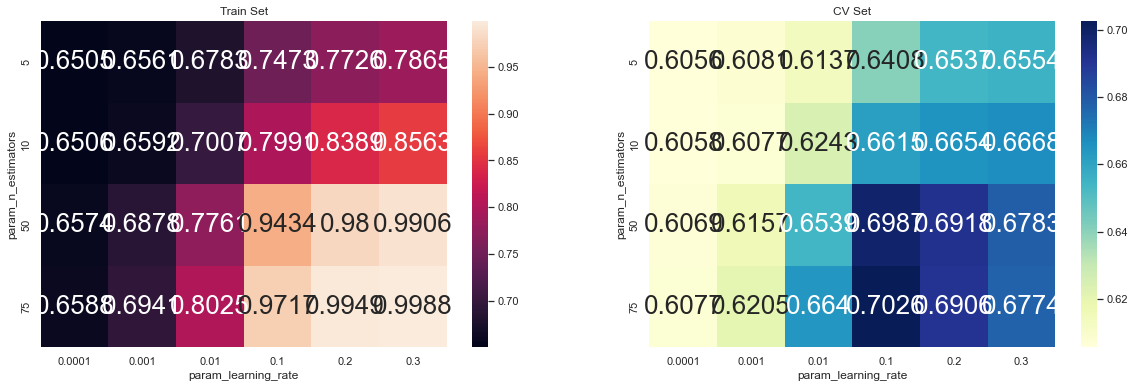

In [38]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
max_scores2 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_learning_rate']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

<h3>1.6.3 Best Model with Category 2 features <h3>

In [39]:
best_model_tfidf1= lgb.LGBMClassifier(boosting_type='gbdt',learning_rate=bestLearningRate2,n_estimators=bestNEstimators2)
best_model_tfidf1.fit(X_tr2,y_train)

LGBMClassifier(n_estimators=50)

In [40]:
y_train_pred1=best_model_tfidf1.predict_proba(X_tr2)[:,1]
predictions_train_set2=best_model_tfidf1.predict(X_tr2)

y_test_pred1=best_model_tfidf1.predict_proba(X_te2)[:,1]
predictions_test_set2=best_model_tfidf1.predict(X_te2)

<h3>1.6.4 Drawing AUC Curve </h3>

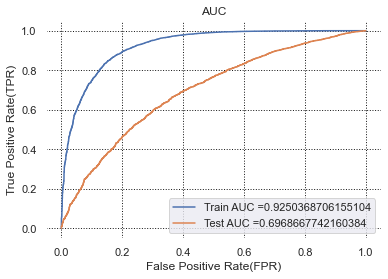

In [41]:
from sklearn.metrics import roc_curve, auc
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)


ax = plt.subplot()

aucScoreTrainingData1=auc(train_fpr1, train_tpr1)
aucScoreTestData1=auc(test_fpr1, test_tpr1)


ax.plot(train_fpr1, train_tpr1, label="Train AUC ="+str(auc(train_fpr1, train_tpr1)))
ax.plot(test_fpr1, test_tpr1, label="Test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<h3>1.6.5 Confusion Matrix </h3>

In [42]:
def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



the maximum value of tpr*(1-fpr) 0.7192635985549974 for threshold 0.816

Train confusion matrix


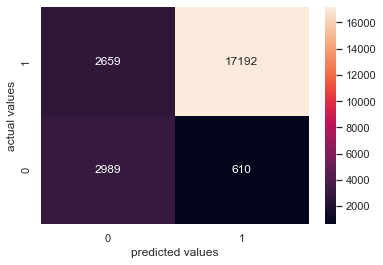

Test confusion matrix


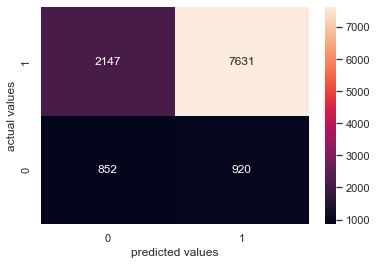

In [43]:
from sklearn.metrics import confusion_matrix
best_t1 = bestthreshold(tr_thresholds1, train_fpr1, train_tpr1)
print()
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(y_train, predictusingbestt(y_train_pred1, best_t1)),annot=True,fmt='d')
ax.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx = sns.heatmap(confusion_matrix(y_test, predictusingbestt(y_test_pred1, best_t1)),annot=True,fmt='d')
bx.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

<h1>2. Summary</h1>


In [44]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "n_estimator","learning_rate", "Train AUC", "Test AUC"]


x.add_row(["TF-IDF", "GBDT", bestNEstimators1,bestLearningRate1,aucScoreTrainingData,aucScoreTestData1])
x.add_row(["TF-IDF W2V", "GBDT", bestNEstimators2,bestLearningRate2,aucScoreTrainingData1,aucScoreTestData1])



print(x)

+------------+-------+-------------+---------------+--------------------+--------------------+
| Vectorizer | Model | n_estimator | learning_rate |     Train AUC      |      Test AUC      |
+------------+-------+-------------+---------------+--------------------+--------------------+
|   TF-IDF   |  GBDT |      75     |      0.1      | 0.9390211661484897 | 0.6968667742160384 |
| TF-IDF W2V |  GBDT |      50     |      0.1      | 0.9250368706155104 | 0.6968667742160384 |
+------------+-------+-------------+---------------+--------------------+--------------------+
